# BigramsVectorizer  
  
Notre BigramsVectorizer est enfaite une variante de CountVectorizer, nous utilisons des bigrammes, des paires consécutives de mots dans un texte. Plus précisément, une séquence de deux mots adjacents qui apparaissent dans cet ordre particulier.  

Le rôle principal de CountVectorizer est de convertir des documents textuels en une représentation numérique, compréhensible par les algorithmes d'apprentissage automatique. Il crée une matrice de dimensions qui indique combien de fois chaque Token apparaît dans le corpus de document. Cette matrice permet par la suite d'entraîner des modèles de classification.

## Import
Nous utiliserons une stack de Data Science habituelle : `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [1]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Data/1.normalized_dataset_max.csv")

Cette étape n'est pas nécessaire pour notre étude, elle est en doublon de [y_cat_num]()

In [3]:
df['cluster'] = 0
df.loc[df['product_category_tree'] == 'Home Furnishing', 'cluster'] = 0
df.loc[df['product_category_tree'] == 'Baby Care', 'cluster'] = 1
df.loc[df['product_category_tree'] == 'Watches', 'cluster'] = 2
df.loc[df['product_category_tree'] == 'Home Decor & Festive Needs', 'cluster'] = 3
df.loc[df['product_category_tree'] == 'Kitchen & Dining', 'cluster'] = 4
df.loc[df['product_category_tree'] == 'Beauty and Personal Care', 'cluster'] = 5
df.loc[df['product_category_tree'] == 'Computers', 'cluster'] = 6

Nous pouvons constater 7 catégories distinctives dans la segmentation des produits du dataset.

In [4]:
l_cat = list(set(df['product_category_tree']))
print("catégories : ", l_cat)

catégories :  ['Home Decor & Festive Needs', 'Beauty and Personal Care', 'Kitchen & Dining', 'Computers', 'Watches', 'Baby Care', 'Home Furnishing']


Pour notre travail de segmentation des produits nous devons simplifier la catégorisation des produits pour le modèle de Machine Learning. Nous remplaçons donc les catégories par des chiffres, plus simple à interpréter.

In [5]:
y_cat_num = []

for i in range(len(df)):
    category = df.iloc[i]['product_category_tree']
    index_of_category = l_cat.index(category)
    transformed_value = 1 - index_of_category
    y_cat_num.append(transformed_value)

Nous comptons ensuite le nombre d'occurrences de chaque mot dans le corpus avec [CountVetorizer]() qui crée un vecteur pour chaque individu.  
[fit_transform]() transforme les données en une représentation numérique plus simple à comprendre pour le modèle de Machine Learning.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

df['words'] = df['words'].astype(str)
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(df['words'])

df_word_count = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

Nous utilisons ensuite la technique de réduction de dimensionnalité [t-SNE]() (t-distributed Stochastic Neighbor Embedding) pour transformer la matrice de donnée [X](), en un espace bidimensionnel.

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

df_tsne = pd.DataFrame({"tsne_1" : X_tsne[:, 0], "tsne_2" : X_tsne[:, 1], "cluster" : df['cluster']})

In [8]:
X = df_tsne.drop('cluster', axis=1).values

Nous utilisons ensuite un modèle de ML : le [K-Means]().
Il permet d’analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes (ou clusters). Il minimise la somme des variances intra-cluster.
Ici nous appliquons ce modèle sur nos données réduites car cette méthode permet de valider la pertinence d'une segmentation de produits par leur description textuelle. Cela nous permet également d'identifier plus facilement les différents groupes de mots qui ont permis une bonne segmentation. Si notre étude valide la possibilité d'utiliser les données textuelles pour effectuer une classification automatique de produits, nous utiliserons alors les données réelles plutôt que les données réduites.

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
df_tsne['cluster_predict'] = kmeans.fit_predict(X)

Pour évaluer la pertinence de notre modèle de clustering nous devons recaller les cluster créés par notre K-means avec les catégories de produits réelles. Pour ce faire nous étudions rapidement quel cluster a été créé et correspond à une catégorie réelle. Si le numéro de cluster n'est pas correect nous le corrigons.

In [10]:
def determine_cluster():
    for i in range(7):
        print(f"Valeurs les plus fréquentes pour le cluster prédit {i}")
        print(df_tsne[df_tsne['cluster_predict'] == i]['cluster'].value_counts())
determine_cluster()

Valeurs les plus fréquentes pour le cluster prédit 0
cluster
6    98
4    27
5    26
3    21
1    17
2    13
0     4
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 1
cluster
2    124
5      8
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 2
cluster
6    25
4    22
0    21
1    10
3    10
2    10
5     9
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 3
cluster
1    76
4    32
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 4
cluster
3    81
4    36
6    14
1     5
5     3
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 5
cluster
5    86
4     3
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 6
cluster
0    125
1     42
3     38
4     30
5     18
6     13
2      3
Name: count, dtype: int64


In [11]:
from sklearn import metrics

def conf_mat_transform(y_true,y_pred) :
    corresp = [6, 2, 4, 1, 3, 5, 0]

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(df_tsne['cluster'], kmeans.labels_)
conf_mat = metrics.confusion_matrix(df_tsne['cluster'], kmeans.labels_)
conf_matX = metrics.confusion_matrix(df_tsne['cluster'], cls_labels_transform)
print(conf_mat)
print("--------------------------------")
print(conf_matX)

[[  4   0  21   0   0   0 125]
 [ 17   0  10  76   5   0  42]
 [ 13 124  10   0   0   0   3]
 [ 21   0  10   0  81   0  38]
 [ 27   0  22  32  36   3  30]
 [ 26   8   9   0   3  86  18]
 [ 98   0  25   0  14   0  13]]
--------------------------------
[[125   0   0   0  21   0   4]
 [ 42  76   0   5  10   0  17]
 [  3   0 124   0  10   0  13]
 [ 38   0   0  81  10   0  21]
 [ 30  32   0  36  22   3  27]
 [ 18   0   8   3   9  86  26]
 [ 13   0   0  14  25   0  98]]


Pour évaluer les performances de notre modèle de classification nous utilisons une matrice de confusion. Elle permet de visualiser le nombre de prédictions correctes et incorrectes faites par notre modèle comparé aux classes réelles dans un ensemble de données. La matrice de confusion est simple de compréhension lorsque nous avons à faire à une segmentation binaire, mais peut s'avérer plus difficilement interprétable lorsqu'il s'agit d'une segmentation multi-classe. Ci-dessous un schéma pour pouvoir interpréter les résultats en additionnant les valeurs correspondantes. 

![image](https://www.researchgate.net/profile/Frank-Krueger-2/publication/314116591/figure/fig7/AS:614085901185031@1523420896093/Confusion-matrix-for-multi-class-classification-The-confusion-matrix-of-a.png)

- Vraies positives (True Positives - TP) : nombre d'observations qui ont été correctement prédites comme appartenant à la classe positive par le modèle.

- Vraies négatives (True Negatives - TN) : nombre d'observations qui ont été correctement prédites comme n'appartenant pas à la classe positive par le modèle.

- Faux positifs (False Positives - FP) : nombre d'observations qui ont été incorrectement prédites comme appartenant à la classe positive par le modèle alors qu'elles n'y appartiennent pas réellement.

- Faux négatifs (False Negatives - FN) : nombre d'observations qui ont été incorrectement prédites comme n'appartenant pas à la classe positive par le modèle alors qu'elles appartiennent réellement à cette classe.

Par le biais de cette matrice de confusion nous pouvons par la suite obtenir différentes métrics de performances pour évaluer notre modèle et sélectionner le meilleur.

- Precision : Mesure la proportion d'observations positives correctement identifiées parmi toutes les observations identifiées comme positives par le modèle.
- Recall : Mesure la proportion d'observations positives correctement identifiées parmi toutes les observations réellement positives.
- F1-score : métrique qui combine à la fois la précision et le rappel
- Accuracy : Mesure la proportion d'observations correctement classées parmi l'ensemble des observations.
- Macro avg : moyenne arithmétique des métriques pour chaque classe.
- Weighted avg : moyenne des métriques en tenant compte du nombre d'occurrences de chaque classe.

In [12]:
print(metrics.classification_report(df_tsne['cluster'], cls_labels_transform))

              precision    recall  f1-score   support

           0       0.46      0.83      0.60       150
           1       0.70      0.51      0.59       150
           2       0.94      0.83      0.88       150
           3       0.58      0.54      0.56       150
           4       0.21      0.15      0.17       150
           5       0.97      0.57      0.72       150
           6       0.48      0.65      0.55       150

    accuracy                           0.58      1050
   macro avg       0.62      0.58      0.58      1050
weighted avg       0.62      0.58      0.58      1050



Puis nous pouvons afficher graphiquement la segmentation des produits avec les catégories des individus représenté par nuage de point et la segmentation prédite par l'algorithme k-means. Ainsi nous pouvons constater que la segmentation réalisé par le modèle arrive à reproduire la segmentation réelle des catégories de produits. Mais lorsque les points sont agglomérés dans un nuage indistinc, le modèle ne reproduit pas correctement le clustering.

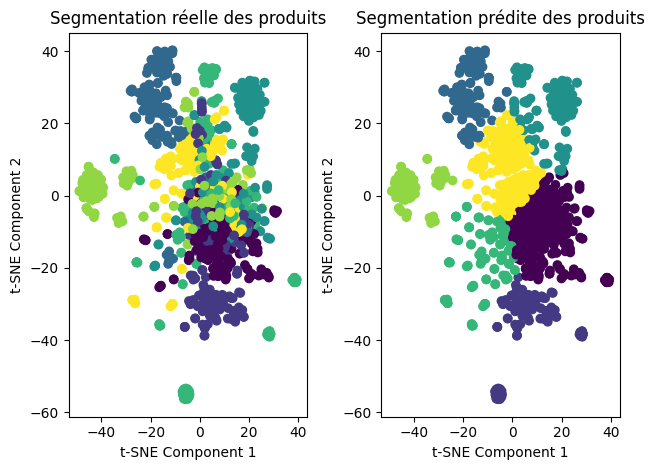

In [13]:
plt.subplot(1, 2, 1)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation réelle des produits')

plt.subplot(1, 2, 2)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=cls_labels_transform, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation prédite des produits')

plt.tight_layout()
plt.show()

Il convient en plus d'une analyse graphique de réaliser une analyse technique de la segmentation réalisé par le modèle k-means. Pour cela nous utilisons l'[ARI](), (Adjusted Rand Index), une mesure de similarité entre deux ensembles d'éléments, souvent utilisée pour évaluer la qualité d'une partition dans le contexte de l'analyse de clustering. Cette metric mesure la similarité entre les regroupements produits par un algorithme de clustering et les regroupements réels ou attendus, en prenant en compte le hasard.

In [14]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, kmeans.labels_),4)
ARI

0.3142